In [1]:
################################################################################
# Copyright 2022 E. Kooistra
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
################################################################################
#
# Author: E. Kooistra, March 2022 creation
#                      July 2024 updated
# Purpose:
#   Calculate swivel OutputTube position and thrust pointing as function of
#   MidTube rotation.
# Description:
# * The swivel consist of InputTube, MidTube and OutputTube. The tubes connect
#   at an angle of alpha_tilt degrees.
#   . alpha_tilt is the tilt angle at which the tubes connect to eachother.
#   . theta_mid is the MidTube rotation in the alpha_tilt plane.
#   . theta_output_zx is the OutputTube thrust vector angle in the ZX plane.
#   . theta_output_xr is the OutputTube thrust vector angle with respect to
#     the x-axis
#   . phi_input_yz is the angle in the YZ plane of the long side marker of the
#     InputTube.
#   . phi_output_yz is the angle in the YZ plane of the OutputTube.
# * Swivel control
#   . output_tube_pointing: for 'down' or 'up' control of the OutputTube.
#     This is 'down' for hovering an airplane.
#   . mid_tube_rotation: for 'positive' or 'negative' rotation angles of
#     theta_mid of the MidTube. This defines the swivel mounting, regarding YZ
#     orientation, in an airplane.

In [2]:
import importlib  # to reload a library when modified
import os.path
import numpy as np
import matplotlib.pyplot as plt

print(np.__version__)

1.19.2


In [3]:
import linear_algebra as la
importlib.reload(la)

<module 'linear_algebra' from 'D:\\git\\openscad\\math\\python\\linear_algebra.py'>

In [4]:
import swivel_functions as sw
importlib.reload(sw)

<module 'swivel_functions' from 'D:\\git\\Swivel\\python\\swivel_functions.py'>

# 1. Swivel parameters

In [5]:
# Swivel tube segment
alpha_tilt = 25  # Segment tilt angle [degrees]
x_input = 50     # Length of InputTube segment
x_mid = 80       # Length of MidTube segment
x_output = 40    # Length of OutputTube segment

# Swivel control
N_points = 1024  # over 360 degrees of theta_mid
N_degrees = 360
N_periods = 2

theta_mid_resolution = N_degrees / N_points
angle_yz_resolution = 0.2

print('N_points                   = %d' % N_points)
print('N_degrees                  = %d' % N_degrees)
print('N_periods                  = %d' % N_periods)
print('theta_mid_resolution       = %.3f' % theta_mid_resolution)
print('angle_yz_resolution        = %.3f' % angle_yz_resolution)

N_points                   = 1024
N_degrees                  = 360
N_periods                  = 2
theta_mid_resolution       = 0.352
angle_yz_resolution        = 0.200


In [6]:
# Uncomment to select control option
output_tube_pointing = 'down'; mid_tube_rotation = 'positive'
#output_tube_pointing = 'down'; mid_tube_rotation = 'negative'
#output_tube_pointing = 'up'; mid_tube_rotation = 'positive'
#output_tube_pointing = 'up'; mid_tube_rotation = 'negative'

sa = sw.SwivelAngles(alpha_tilt, output_tube_pointing, mid_tube_rotation)
sa.LogSwivelAngles()

Input parameters:
. alpha_tilt                 = 25
. output_tube_pointing       = down
. mid_tube_rotation          = positive
Constant swivel angles:
. swivel_tilt_vertical                     = 90
. phi_input_yz_for_marker_up               = 90
. phi_input_yz_for_analysis                = 270
. phi_output_yz_for_analysis               = 0
. theta_mid_to_phi_output_yz_crosstalk_max = 90
. theta_output_zx_horizontal               = 90
. theta_output_zx_horizontal               = 90
Derived from alpha_tilt:
. swivel_tilt_max            = 100
. theta_output_zx_max        = 190
. theta_output_zx_min        = -10
Derived from output_tube_pointing:
. phi_output_yz_vertical     = 270
. phi_input_yz_vertical      = 90
. theta_output_zx_vertical   = 180
Derived from output_tube_pointing and mid_tube_rotation:
. phi_input_yz_horizontal    = 180
. phi_output_yz_horizontal   = 180


In [7]:
sa.LogYzAnglesTable()

                     phi_output_yz  phi_input_yz  phi_input_yz  phi_output_yz
                          vertical      vertical    horizontal     horizontal
           theta_mid:          180           180             0              0
swivel
output    mid_tube
pointing  rotation
  down      positive:          270            90           180            180
  down      negative:          270            90             0              0
  up        positive:           90           270             0              0
  up        negative:           90           270           180            180


# 2. Calculate swivel thrust vector

In [8]:
# No need to calculate swivel position vector (p_vector), only need to use swivel
# thrust vector (t_vector) to determine swivel pointing, because:
# . phi_output_yz = fAngleYZ(t_vector) = fAngleYZ(p_vector)
# . theta_output_xr = fAngleXR(t_vector)
theta_mid_periods_arr = np.linspace(0, N_degrees * N_periods, N_points * N_periods, endpoint=False)
    
# Do analysis with InputTube YZ angle that yields phi_output_yz_analysis_arr[theta_mid = 0] = 0
phi_input_yz_for_analysis_arr = [sa.phi_input_yz_for_analysis] * N_points * N_periods
t_vector_list = sw.SwivelThrustVectorsList(x_input, x_mid, x_output, alpha_tilt,
                                           phi_input_yz_for_analysis_arr, theta_mid_periods_arr)
phi_output_yz_analysis_arr = la.toAngleArr360(la.fAngleArrYZ(t_vector_list))
# Do analysis with OutputTube XR angle, so independent of YZ angle
theta_output_xr_analysis_arr = la.fAngleArrXR(t_vector_list)
    
# replace phi_output_yz_analysis_arr[theta_mid = 0] = nan, when OutputTube is horizontal
# at x-axis (so z/y = 0/0)
print('sa.phi_input_yz_for_analysis  = %.0f' % sa.phi_input_yz_for_analysis)
print('sa.phi_output_yz_for_analysis = %.0f' % sa.phi_output_yz_for_analysis)
print('')
print('phi_output_yz_analysis_arr = ', phi_output_yz_analysis_arr)
print('np.isnan(phi_output_yz_analysis_arr) = ', np.isnan(phi_output_yz_analysis_arr))
phi_output_yz_analysis_arr[np.isnan(phi_output_yz_analysis_arr)] = sa.phi_output_yz_for_analysis

sa.phi_input_yz_for_analysis  = 270
sa.phi_output_yz_for_analysis = 0

phi_output_yz_analysis_arr =  [           nan 1.59312005e-01 3.18624546e-01 ... 1.79522062e+02
 1.79681375e+02 1.79840688e+02]
np.isnan(phi_output_yz_analysis_arr) =  [ True False False ... False False False]


# 3. Analyze swivel phi_output_yz angle

## 3.1 Exact phi_output_yz(theta_mid)

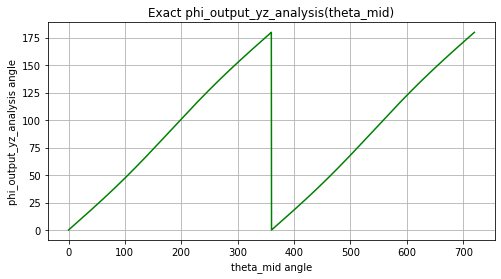

In [9]:
# phi_output_yz angle in YZ plane as function of theta_mid
# . analyse linearity to see if a linear approximation is sufficiently
#   accurate --> phi_output_yz_diff_arr is too large
# . check symmetry to see if a smaller lookup table is possible to
#   lookup phi_output_yz from theta_mid --> phi_output_yz_diff_arr is
#   exactly symmetrical over 0 to 360 around theta_mid = 180
fig = plt.figure(figsize=(8, 4))  # width, height in inches
plt.plot(theta_mid_periods_arr, phi_output_yz_analysis_arr, 'g-')
plt.title('Exact phi_output_yz_analysis(theta_mid)')
plt.xlabel('theta_mid angle')
plt.ylabel('phi_output_yz_analysis angle')
plt.grid()
# save figure: phi_output_yz(theta_mid)
filename = os.path.normpath("../Pictures/phi_output_yz_as_function_of_theta_mid.jpg")
plt.savefig(filename)

**Discontinuity in OutputTube YZ angle when MidTube angle is 0:**

The swivel OutputTube YZ angle jumps between 0 and 180 when the MidTube angle is +0 and -0. With a real swivel this is barely noticable, because the swivel is straight when the MidTube angle is 0, so then the OutputTube YZ angle is actually undefined. Therefore replace theta_mid = 0 by +c_theta_mid_eps (~= +0) when mid_tube_rotation is positive, else by 360 - c_theta_mid_eps (~= -0) when mid_tube_rotation is negative.

**Rotate MidTube 180 degrees:**

A MidTube rotation range of 180 degrees is sufficient to control the swivel tilt. Rotate the MidTube from 0 to 180 degrees to point the swivel from straight to maximum tilted. Rotate the MidTube back from 180 to 0 to point the swivel from maximum tilted back to horizontal.

**Continuously rotating MidTube:**

A continuously rotating MidTube is not applicable for an airplane, but can be simulated.
* If InputTube YZ is kept fixed, then the swivel OutputTube YZ will periodically: point straight, tilt to maximum, move back to straight.
* If InputTube YZ is incremented by 180 when the MidTube angle crosses 0 (so after every MidTube rotation), then the swivel OutputTube will periodically: point straight, tilt to maximum, move back to straight, tilt to opposite maximum, move back to straight. Hence two rotations (720 degrees) of the MidTube then yield one rotation (360 degrees) of the swivel OutputTube.

In [10]:
# Keep one period of of the MidTube rotation
theta_mid_360_arr = theta_mid_periods_arr[:N_points]
phi_output_yz_analysis_arr = phi_output_yz_analysis_arr[:N_points]
theta_output_xr_analysis_arr = theta_output_xr_analysis_arr[:N_points]

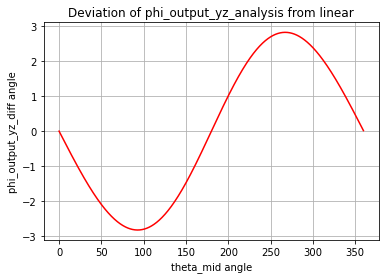

In [11]:
# Deviation of phi_output_yz from linear part
phi_linear_part_arr = sa.phi_output_yz_for_analysis + theta_mid_360_arr / 2
phi_output_yz_diff_arr = phi_output_yz_analysis_arr - phi_linear_part_arr

plt.plot(theta_mid_360_arr, phi_output_yz_diff_arr, 'r-')
plt.title('Deviation of phi_output_yz_analysis from linear')
plt.xlabel('theta_mid angle')
plt.ylabel('phi_output_yz_diff angle')
plt.grid()

In [12]:
# Check symmetry in phi_output_yz_diff_arr for 0 < theta_mid < 360
flip360_phi_output_yz_diff_arr = np.flip(phi_output_yz_diff_arr[0:N_points])
# skip theta_mid = 0, because symmetry point theta_mid = 360 is not in phi_output_yz_diff_arr
symm360_phi_output_yz_diff_arr = phi_output_yz_diff_arr[1:] + flip360_phi_output_yz_diff_arr[0:-1]
preStr = 'The deviation of phi_output_yz from linear is'
postStr = 'symmetrical over theta_mid = 0:180 and 360:180 degrees.'
max_abs_symm360_phi_output_yz_diff_arr = np.max(np.abs(symm360_phi_output_yz_diff_arr))
if max_abs_symm360_phi_output_yz_diff_arr < la.f_eps:
    print('%s EXACTLY %s' % (preStr, postStr))
else:
    if max_abs_symm360_phi_output_yz_diff_arr < angle_yz_resolution:
        print('%s NEARLY %s' % (preStr, postStr))
        print('. max_abs_symm180_phi_output_yz_diff_arr = %.3f degrees' % max_abs_symm360_phi_output_yz_diff_arr)
    else:
        print('%s NOT %s' % (preStr, postStr))

    plt.plot(theta_mid_360_arr[1:], symm360_phi_output_yz_diff_arr, 'r-')
    plt.title('Symmetry 360 of phi_output_yz_analysis deviation from linear')
    plt.xlabel('theta_mid angle')
    plt.ylabel('symm360_phi_output_yz_diff angle')
    plt.grid()

The deviation of phi_output_yz from linear is EXACTLY symmetrical over theta_mid = 0:180 and 360:180 degrees.


The deviation of phi_output_yz from linear is NEARLY symmetrical over theta_mid = 0:90 and 180:90 degrees.
. max_abs_symm180_phi_output_yz_diff_arr = 0.138 degrees


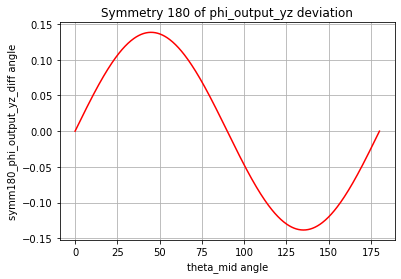

In [13]:
# Check symmetry in phi_output_yz_diff_arr for 0 < theta_mid < 180
select180 = range(0, N_points * 180 // N_degrees + 1)  # +1 to have symmetric flip
flip180_phi_output_yz_diff_arr = np.flip(phi_output_yz_diff_arr[select180])
symm180_phi_output_yz_diff_arr = phi_output_yz_diff_arr[select180] - flip180_phi_output_yz_diff_arr
preStr = 'The deviation of phi_output_yz from linear is'
postStr = 'symmetrical over theta_mid = 0:90 and 180:90 degrees.'
max_abs_symm180_phi_output_yz_diff_arr = np.max(np.abs(symm180_phi_output_yz_diff_arr)) 
if max_abs_symm180_phi_output_yz_diff_arr < la.f_eps:
    print('%s EXACTLY %s' % (preStr, postStr))
else:
    if max_abs_symm180_phi_output_yz_diff_arr < angle_yz_resolution:
        print('%s NEARLY %s' % (preStr, postStr))
        print('. max_abs_symm180_phi_output_yz_diff_arr = %.3f degrees' % max_abs_symm180_phi_output_yz_diff_arr)
    else:
        print('%s NOT %s' % (preStr, postStr))
    plt.plot(theta_mid_360_arr[select180], symm180_phi_output_yz_diff_arr, 'r-')
    plt.title('Symmetry 180 of phi_output_yz deviation')
    plt.xlabel('theta_mid angle')
    plt.ylabel('symm180_phi_output_yz_diff angle')
    plt.grid()

**Lookup table for phi_output_yz_diff(theta_mid)**

* For EXACT values a lookup table **one half period** of phi_output_yz_diff(theta_mid) is enough to derive all values
* For NEARLY exact values a lookup table **one quarter period** of phi_output_yz_diff(theta_mid) is enough to derive all values

In [14]:
# Determine harmonics in phi_output_yz_diff_arr using FFT
# . scale by 2/N_points for freq bins and by 1/N_points for DC bin 0
fft_phi_output_yz_diff_arr = 2 / N_points * np.fft.rfft(phi_output_yz_diff_arr)
fft_phi_output_yz_diff_arr[0] = fft_phi_output_yz_diff_arr[0] / 2  # DC bin
ampl_fft_phi_output_yz_diff_arr = np.abs(fft_phi_output_yz_diff_arr)
angle_fft_phi_output_yz_diff_arr = np.degrees(np.angle(fft_phi_output_yz_diff_arr))

if False:
    plt.plot(ampl_fft_phi_output_yz_diff_arr, 'r-')
    plt.title('Frequency components in deviation of phi_output_yz from linear')
    plt.xlabel('frequency')
    plt.ylabel('ampl_fft_phi_output_yz_diff_arr anglee')
    plt.grid()

nof_f = 10
for fi in range(nof_f):
    print('fi = %2d : fi_ampl = %20.18f, fi_angle = %14.10f' %
          (fi, ampl_fft_phi_output_yz_diff_arr[fi], angle_fft_phi_output_yz_diff_arr[fi]))

fi =  0 : fi_ampl = 0.000000000000005664, fi_angle = 180.0000000000
fi =  1 : fi_ampl = 2.816002962662007558, fi_angle =  90.0000000000
fi =  2 : fi_ampl = 0.069201193814899378, fi_angle = -90.0000000000
fi =  3 : fi_ampl = 0.002267424331060616, fi_angle =  90.0000000000
fi =  4 : fi_ampl = 0.000083580418418892, fi_angle = -89.9999999988
fi =  5 : fi_ampl = 0.000003286283323405, fi_angle =  90.0000000096
fi =  6 : fi_ampl = 0.000000134596644143, fi_angle = -89.9999994998
fi =  7 : fi_ampl = 0.000000005670194352, fi_angle =  89.9999985630
fi =  8 : fi_ampl = 0.000000000243845798, fi_angle = -90.0001186596
fi =  9 : fi_ampl = 0.000000000010653876, fi_angle =  90.0034017353


fi = 0 : ampl = 0.0000000000, angle =  180.0
fi = 1 : ampl = 2.8160029627, angle =   90.0


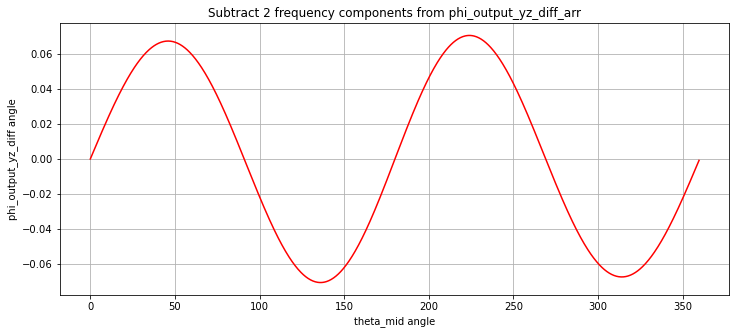

In [15]:
# Subtract frequency components from phi_output_yz_diff_arr
nof_f = 2
sub_phi_output_yz_diff_arr = np.ndarray.copy(phi_output_yz_diff_arr)
for fi in range(0, nof_f):
    fi_ampl = ampl_fft_phi_output_yz_diff_arr[fi]
    fi_angle = angle_fft_phi_output_yz_diff_arr[fi]
    print('fi = %d : ampl = %.10f, angle = %6.1f' % (fi, fi_ampl, fi_angle))
    sub_phi_output_yz_diff_arr -= fi_ampl * np.cos(np.radians(fi * theta_mid_360_arr + fi_angle))

fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.plot(theta_mid_360_arr, sub_phi_output_yz_diff_arr, 'r-')
plt.title('Subtract %d frequency components from phi_output_yz_diff_arr' % nof_f)
plt.xlabel('theta_mid angle')
plt.ylabel('phi_output_yz_diff angle')
plt.grid()

## 3.1 Approximate phi_output_yz(theta_mid)

In [16]:
# Single harmonic approximation for phi_output_yz as function of theta_mid
# . sw.rfft_bins_of_phi_output_yz_as_function_of_theta_mid() and
#   sw.approximate_phi_output_yz_as_function_of_theta_mid() implement
#   the steps that were analysed above.
# Determine harmonics in exact phi_output_yz(theta_mid)
rfft_phi_output_yz_diff_ampl_arr, rfft_phi_output_yz_diff_angle_arr = \
    sw.rfft_bins_of_phi_output_yz_as_function_of_theta_mid(alpha_tilt, N_points)
f1_phi_output_yz_ampl = rfft_phi_output_yz_diff_ampl_arr[1]
phi_output_yz_crosstalk_arr = sw.approximate_phi_output_yz_crosstalk(theta_mid_360_arr,
                                                                     f1_phi_output_yz_ampl)
print('phi_output_yz_analysis_arr =', phi_output_yz_analysis_arr)
print('phi_output_yz_crosstalk_arr =', phi_output_yz_crosstalk_arr)

rfft_bins_of_phi_output_yz_as_function_of_theta_mid()
. phi_input_yz_for_analysis =  270
. phi_output_yz_for_analysis =  0
. f0 = 0 : f0_ampl = 0.0000000000, f0_angle = 180.0000000000, = DC = PhiOutputYzForAnalysis()
. f1 = 1 : f1_ampl = 2.8160029627, f1_angle = 90.0000000000
. Use cos(t + f1_angle) = cos(t + 90) = -sin(t)
phi_output_yz_analysis_arr = [0.00000000e+00 1.59312005e-01 3.18624546e-01 ... 1.79522062e+02
 1.79681375e+02 1.79840688e+02]
phi_output_yz_crosstalk_arr = [0.00000000e+00 1.58502581e-01 3.17005812e-01 ... 1.79524490e+02
 1.79682994e+02 1.79841497e+02]


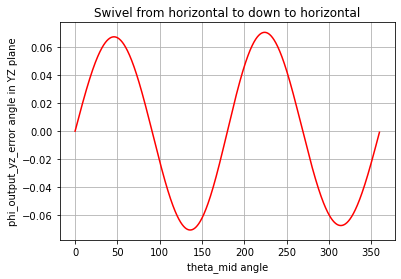

In [17]:
# Plot error in approximated phi_output_yz_crosstalk_arr(theta_mid)
phi_output_yz_error_arr = phi_output_yz_analysis_arr - phi_output_yz_crosstalk_arr
                      
plt.plot(theta_mid_360_arr, phi_output_yz_error_arr, 'r')
plt.title('Swivel from horizontal to ' + output_tube_pointing + ' to horizontal')
plt.xlabel('theta_mid angle')
plt.ylabel('phi_output_yz_error angle in YZ plane')
plt.grid()

## 3.2 InputTube control near horizontal for vertical swivel OutputTube

In [18]:
result = sw.log_and_verify_input_tube_control_near_horizontal(f1_phi_output_yz_ampl)
sw.log_result(result)

>>> Verify log_and_verify_input_tube_control_near_horizontal():
sa.phi_input_yz_for_analysis = 270
sa.phi_output_yz_for_analysis = 0
f1_phi_output_yz_ampl = 2.816002962662007

swivel                                                          
output    mid_tube               phi_input_yz   phi_output_yz   phi_input_yz                  f1_phi_output_yz_ampl *
pointing  rotation    theta_mid  control        vertical        for_analysis    theta_mid/2   sin(theta_mid)
  down      positive:        +0     180       =   270         +    270        -       0     +    0
  down      negative:        -0       0       =   270         +    270        -     180     +   -0
  up        positive:        +0       0       =    90         +    270        -       0     +    0
  up        negative:        -0     180       =    90         +    270        -     180     +   -0


PASSED


## 3.3 **Conclusion: Approximate InputTube YZ angle control**
Approximate swivel InputTube YZ angle phi_input_yz_control, as function OutputTube YZ angle phi_output_yz_request, and MidTube angle theta_mid:

```
phi_input_yz_control = phi_output_yz_request - phi_output_yz_approx(theta_mid)

phi_output_yz_approx(theta_mid) ~= -phi_input_yz_for_analysis + theta_mid / 2 - f1_phi_output_yz_ampl * sin(theta_mid)
    with:
    . phi_input_yz_for_analysis = -90
    . theta_mid in [0 : 360>
    . f1_phi_output_yz_ampl = first harmonic from DFT of harmonic part in exact phi_output_yz(theta_mid),
        few degrees, approximates the small deviation from linear crosstalk, 
```

# 4. Analyze swivel thrust theta_output_xr angle

## 4.1 Exact theta_output_xr(theta_mid)

min(theta_output_xr_analysis) = 0.0
max(theta_output_xr_analysis) = 100.0


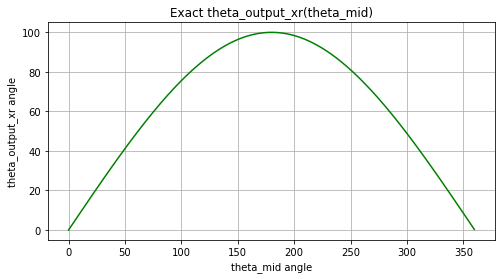

In [19]:
# theta_output_xr angle as function of theta_mid
# . check symmetry to see if a smaller lookup table is possible to
#   lookup theta_output_xr from theta_mid --> theta_output_xr is exactly 
#   symmetrical over 0 to 360 around theta_mid = 180
fig = plt.figure(figsize=(8, 4))  # width, height in inches
plt.plot(theta_mid_360_arr, theta_output_xr_analysis_arr, 'g-')
plt.title('Exact theta_output_xr(theta_mid)')
plt.xlabel('theta_mid angle')
plt.ylabel('theta_output_xr angle')
plt.grid()
# save figure: theta_output_xr(theta_mid)
filename = os.path.normpath("../Pictures/theta_output_xr_as_function_of_theta_mid.jpg")
plt.savefig(filename)

# Expect theta_output_xr in range 0 to 90 + 4 * alpha_tilt
print('min(theta_output_xr_analysis) = %.1f' % np.min(theta_output_xr_analysis_arr))
print('max(theta_output_xr_analysis) = %.1f' % np.max(theta_output_xr_analysis_arr))

In [20]:
# Check symmetry in theta_output_xr_analysis_arr for 0 < theta_mid < 360
flip360_theta_output_xr_arr = np.flip(theta_output_xr_analysis_arr)
# skip theta_mid = 0, because symmetry point theta_mid = 360 is not in theta_output_xr_analysis_arr
symm360_theta_output_xr_arr = theta_output_xr_analysis_arr[1:] - flip360_theta_output_xr_arr[0:-1]
if np.max(np.abs(symm360_theta_output_xr_arr)) < la.f_eps:
    print('The theta_output_xr is EXACTLY symmetrical over 360 degrees.')
else:
    if np.max(np.abs(symm360_theta_output_xr_arr)) < angle_yz_resolution:
        print('The theta_output_xr is NEARLY symmetrical over 360 degrees.')
    else:
        print('The theta_output_xr is NOT symmetrical over 360 degrees.')
        
    plt.plot(theta_mid_360_arr[1:], symm360_theta_output_xr_arr, 'r-')
    plt.title('Symmetry 360 of theta_output_xr')
    plt.xlabel('theta_mid angle')
    plt.ylabel('symm360_theta_output_xr angle')
    plt.grid()

The theta_output_xr is EXACTLY symmetrical over 360 degrees.


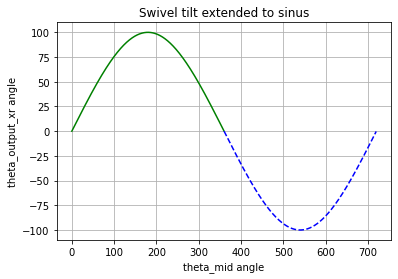

In [21]:
# Create symmetrical sinus like signal from theta_output_arr
symm_theta_mid_arr = N_degrees + theta_mid_360_arr  # theta_mid in [360 : 720> degrees
symm_theta_output_xr_arr = -theta_output_xr_analysis_arr

plt.plot(theta_mid_360_arr, theta_output_xr_analysis_arr, 'g-',
         symm_theta_mid_arr, symm_theta_output_xr_arr, 'b--')
plt.title('Swivel tilt extended to sinus')
plt.xlabel('theta_mid angle')
plt.ylabel('theta_output_xr angle')
plt.grid()

In [22]:
# Determine harmonics in theta_output_arr2 using FFT
# . arr2 range for theta_mid in [0:720> 
N_points2 = 2 * N_points
theta_mid_arr2 = np.append(theta_mid_360_arr, symm_theta_mid_arr)
theta_output_xr_arr2 = np.append(theta_output_xr_analysis_arr, symm_theta_output_xr_arr)

# . scale by 2 / N_points2 for freq bins and by 1 / N_points2 for DC bin 0
fft_theta_output_xr_arr = 2 / N_points2 * np.fft.rfft(theta_output_xr_arr2)
fft_theta_output_xr_arr[0] = fft_theta_output_xr_arr[0] / 2  # DC bin
fft_theta_output_xr_ampl_arr = np.abs(fft_theta_output_xr_arr)
fft_theta_output_xr_angle_arr = np.degrees(np.angle(fft_theta_output_xr_arr))

if False:
    plt.plot(fft_theta_output_xr_ampl_arr, 'r-')
    plt.title('Frequency components in theta_output_xr_arr')
    plt.xlabel('frequency')
    plt.ylabel('fft_theta_output_xr_ampl angle')
    plt.grid()

nof_f = 15
for fi in range(nof_f):
    print('fi = %2d : ampl = %20.18f, angle = %14.10f' %
          (fi, fft_theta_output_xr_ampl_arr[fi], fft_theta_output_xr_angle_arr[fi]))

fi =  0 : ampl = 0.000000000000000000, angle =   0.0000000000
fi =  1 : ampl = 99.179360973761930609, angle = -90.0000000000
fi =  2 : ampl = 0.000000000000000000, angle =   0.0000000000
fi =  3 : ampl = 0.802431588024202891, angle =  90.0000000000
fi =  4 : ampl = 0.000000000000000000, angle =   0.0000000000
fi =  5 : ampl = 0.017673589176769929, angle = -90.0000000000
fi =  6 : ampl = 0.000000000000000000, angle =   0.0000000000
fi =  7 : ampl = 0.000515964517513054, angle =  89.9999999998
fi =  8 : ampl = 0.000000000000000000, angle =   0.0000000000
fi =  9 : ampl = 0.000017236506752369, angle = -90.0000000047
fi = 10 : ampl = 0.000000000000000000, angle =   0.0000000000
fi = 11 : ampl = 0.000000623287701764, angle =  90.0000000077
fi = 12 : ampl = 0.000000000000000000, angle =   0.0000000000
fi = 13 : ampl = 0.000000023746519466, angle = -90.0000004058
fi = 14 : ampl = 0.000000000000000000, angle =   0.0000000000


fi =  0 : ampl =  0.00000, angle =    0.0
fi =  1 : ampl = 99.17936, angle =  -90.0


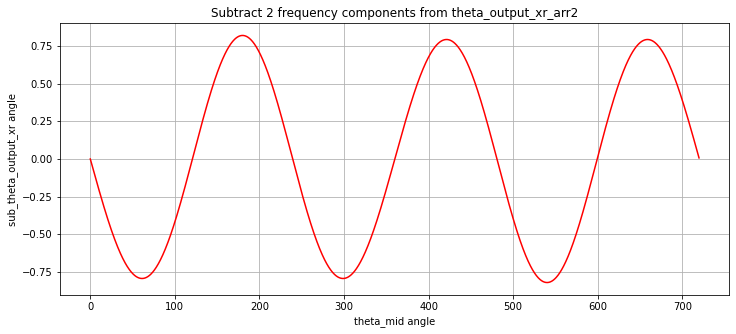

In [23]:
# Subtract frequency components from theta_output_xr_arr2
nof_f = 2
sub_theta_output_xr_arr2 = np.copy(theta_output_xr_arr2)
for fi in range(0, nof_f):
    ampl = fft_theta_output_xr_ampl_arr[fi]
    angle = fft_theta_output_xr_angle_arr[fi]
    print('fi = %2d : ampl = %8.5f, angle = %6.1f' % (fi, ampl, angle))
    sub_theta_output_xr_arr2 -= ampl * np.cos(np.radians(fi * theta_mid_arr2 / 2 + angle))

fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.plot(theta_mid_arr2, sub_theta_output_xr_arr2, 'r-')
plt.title('Subtract %d frequency components from theta_output_xr_arr2' % nof_f)
plt.xlabel('theta_mid angle')
plt.ylabel('sub_theta_output_xr angle')
plt.grid()

## 4.1 Approximate theta_output_xr(theta_mid)

In [24]:
# Single harmonic approximation for theta_output_xr(theta_mid)
# . sw.rfft_bins_of_theta_output_xr_as_function_of_theta_mid() and
#   sw.approximate_theta_output_xr_as_function_of_theta_mid() implement
#   the steps that were analysed above.
# Determine harmonics in exact theta_output_xr(theta_mid)
rfft_theta_output_xr_ampl_arr, rfft_theta_output_xr_angle_arr = \
    sw.rfft_bins_of_theta_output_xr_as_function_of_theta_mid(alpha_tilt, N_points)
f1_theta_output_xr_ampl = rfft_theta_output_xr_ampl_arr[1]  # ~= swivel_tilt_max
theta_output_xr_approx_arr = sw.approximate_theta_output_xr_as_function_of_theta_mid(theta_mid_360_arr,
                                                                                     f1_theta_output_xr_ampl)

rfft_bins_of_theta_output_xr_as_function_of_theta_mid()
. f1 =  1 : f1_ampl = 99.1793609738, f1_angle =  -90.0
. Use cos(t + f1_angle) = cos(t - 90) = sin(t)
approximate_theta_output_xr_as_function_of_theta_mid()
. f1_ampl = 99.179


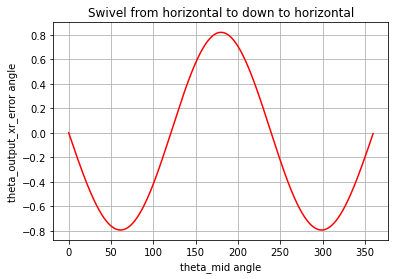

In [25]:
# Plot error in approximated theta_output_xr(theta_mid)
theta_output_xr_error_arr = theta_output_xr_analysis_arr - theta_output_xr_approx_arr

plt.plot(theta_mid_360_arr, theta_output_xr_error_arr, 'r')
plt.title('Swivel from horizontal to ' + output_tube_pointing + ' to horizontal')
plt.xlabel('theta_mid angle')
plt.ylabel('theta_output_xr_error angle')
plt.grid()

## 4.2 **Conclusion: Approximate OutputTube XR angle control** 

### 4.2.1 theta_output_xr(theta_mid)
Approximate swivel OutputTube XR angle theta_output_xr as function of MidTube angle theta_mid:

```
theta_output_xr ~= f1_theta_output_xr_ampl * sin(theta_mid / 2)

    with:
    . f1_theta_output_xr_ampl ~= swivel_tilt_xr_max, first harmonic from rDFT of exact theta_output_xr(theta_mid).
    . theta_mid in [0 : 360>, so sin(theta_mid) >= 0
```

### 4.2.2 theta_mid(theta_output_xr)
Approximate MidTube angle theta_mid as function of swivel OutputTube XR angle theta_output_xr:
```
theta_mid ~= 2 * arcsin(fraction)

    with:
    . f1_theta_output_xr_ampl ~= swivel_tilt_xr_max, first harmonic from rDFT of exact theta_output_xr(theta_mid).
    . fraction = theta_output_xr / f1_theta_output_xr_ampl
      fraction = 1 if fraction > 1 (so theta_output_xr > f1_theta_output_xr_ampl)
      fraction in [0:1], because theta_output_xr >= 0
    . theta_mid in [0:180], because fraction in [0:1]
      theta_mid = c_theta_mid_eps if theta_mid < c_theta_mid_eps ~= 0
      theta_mid in <0:180] when mid_tube_rotation is positive
      theta_mid = 360 - theta_mid, when mid_tube_rotation is negative, so in [180:360> 
```

## 4.3 Find exact theta_output_xr(theta_mid)

In [26]:
# Find theta_mid for theta_output_xr
# . uses binary search in sw.FindThetaMidForThetaOutputXr()
nof_steps = 11
p = 1  # use p > 1 to have finer theta_output_xr resolution in hover range around 90 degrees tilted
p = 4
theta_output_xr_list = np.linspace(0, sa.swivel_tilt_max**p, nof_steps)**(1/p)
theta_output_xr_resolution = 0.01  # resolution in degrees, to determine theta_mid(theta_output_xr)
theta_mid_list = []
theta_mid_prev = np.NaN
print('  theta_output_xr   theta_mid   theta_mid_delta')
print('request    result')
for theta_output_xr_request in theta_output_xr_list:
    theta_mid = sw.FindThetaMidForThetaOutputXr(theta_output_xr_request, theta_output_xr_resolution,
                                                alpha_tilt, mid_tube_rotation)
    t_vector = sw.SwivelThrustVector(x_input, x_mid, x_output, alpha_tilt, 0, theta_mid)
    theta_output_xr = la.fAngleXR(t_vector)
    theta_mid_list.append(theta_mid)
    theta_mid_delta = theta_mid - theta_mid_prev
    theta_mid_prev = theta_mid
    print('%7.3f   %7.3f     %7.3f             %5.1f' %
          (theta_output_xr_request, theta_output_xr, theta_mid, theta_mid_delta))

  theta_output_xr   theta_mid   theta_mid_delta
request    result
  0.000     0.000       0.000               nan
 56.234    56.243      70.181              70.2
 66.874    66.866      85.781              15.6
 74.008    74.011      97.339              11.6
 79.527    79.526     107.161               9.8
 84.090    84.089     116.169               9.0
 88.011    88.019     124.893               8.7
 91.469    91.460     133.682               8.8
 94.574    94.584     143.262               9.6
 97.400    97.410     154.688              11.4
100.000   100.000     180.000              25.3


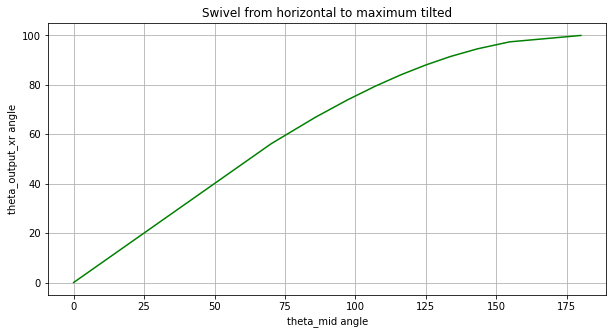

In [27]:
# Plot theta_mid(theta_output_xr)
fig = plt.figure(figsize=(10, 5))  # width, height in inches
plt.plot(theta_mid_list, theta_output_xr_list, 'g-')
plt.title('Swivel from horizontal to maximum tilted')
plt.xlabel('theta_mid angle')
plt.ylabel('theta_output_xr angle')
plt.grid()

# 5 Swivel output pointing control procedure

1. Choose a swivel output pointing via OutputTube YZ angle and OutputTube XR angle
2. Approximate MidTube angle from OutputTube XR angle using sw.approximate_theta_mid_as_function_of_theta_output_xr()
3. Approximate InputTube YZ angle from OutputTube YZ angle and MidTube angle using sw.approximate_phi_output_yz_as_function_of_theta_mid()

# 6. Application: Hover control

Model small swivel output movements around vertical down for hover control. Requires swivel_tilt_max > 90 to be able to move the swivel around vertical down in the ZX plane.

* varying theta_mid yields pitch control (in ZX plane),
* varying phi_input_yz yields yaw control (in YZ plane),
* together pitch and yaw yield hover control in XY plane

Can also model hover with swivel vertical up, this would be practical for an airplane that can hover upside down.

In [28]:
# Define hover motion for circular motion around swivel vertical:
# . theta_output_zx
# . phi_output_yz
print('sa.theta_output_zx_horizontal =', sa.theta_output_zx_horizontal)

# Hover circle radius in XY plane
hover_ampl = f1_theta_output_xr_ampl - sa.swivel_tilt_vertical
print('hover_ampl =', hover_ampl)

# Hover circle angle in XY plane
psi_hover_arr = np.linspace(0, N_degrees, N_points, endpoint=False)

# Vary theta_output_zx in ZX plane for x direction
pitch_arr = hover_ampl * np.cos(np.radians(psi_hover_arr))
request_theta_output_xr_pitch_arr = sa.swivel_tilt_vertical + pitch_arr
if output_tube_pointing == 'down':
    request_theta_output_zx_pitch_arr = sa.theta_output_zx_horizontal + request_theta_output_xr_pitch_arr
else:
    request_theta_output_zx_pitch_arr = sa.theta_output_zx_horizontal - request_theta_output_xr_pitch_arr

# Vary phi_output_yz in YZ plane for y direction
yaw_arr = hover_ampl * np.sin(np.radians(psi_hover_arr))
request_phi_output_yz_yaw_arr = sa.phi_output_yz_vertical + yaw_arr

# Amplitude of circular hover control
ampl_arr = np.sqrt(pitch_arr**2 + yaw_arr**2)

sa.theta_output_zx_horizontal = 90
hover_ampl = 9.17936097376193


In [29]:
# Approximate hover control:
# - hover_theta_mid_arr for MidTube angle
# - hover_phi_input_yz_arr for InputTube YZ angle

# . approximate theta_mid due to theta_output_zx pitch control
hover_theta_mid_arr = sw.approximate_theta_mid_as_function_of_theta_output_xr(
                          request_theta_output_xr_pitch_arr,
                          f1_theta_output_xr_ampl,
                          mid_tube_rotation)
        
# . approximate phi_output_yz due to theta_mid
hover_phi_output_yz_crosstalk_arr = sw.approximate_phi_output_yz_as_function_of_theta_mid(
                                        hover_theta_mid_arr,
                                        f1_phi_output_yz_ampl)

# . adjust phi_input_yz for theta_mid crosstalk, to achieve wanted phi_output_yz
hover_phi_input_yz_arr = request_phi_output_yz_yaw_arr - hover_phi_output_yz_crosstalk_arr

approximate_theta_mid_as_function_of_theta_output_xr()
. f1_ampl = 99.179
. mid_tube_rotation = positive
approximate_phi_output_yz_as_function_of_theta_mid():
. f1_ampl              = 2.816
. phi_input_yz_for_analysis  = 270


In [30]:
# Apply hover control:
t_vector_list = sw.SwivelThrustVectorsList(x_input, x_mid, x_output, alpha_tilt,
                                           hover_phi_input_yz_arr, hover_theta_mid_arr)

# Get OutputTube pointing YZ and ZX angles
result_phi_output_yz_yaw_arr = la.toAngleArr360(la.fAngleArrYZ(t_vector_list))
# . select linear ZX angle range
if output_tube_pointing == 'down':
    result_theta_output_zx_pitch_arr = la.toAngleArr360(la.fAngleArrZX(t_vector_list))
else:
    result_theta_output_zx_pitch_arr = la.toAngleArr180(la.fAngleArrZX(t_vector_list))

In [31]:
# Log arrays
if False:
    print('hover_theta_mid_arr =', hover_theta_mid_arr)
    print('hover_phi_input_yz_arr =', hover_phi_input_yz_arr)
    print('request_phi_output_yz_yaw_arr =', request_phi_output_yz_yaw_arr)
    print('hover_phi_output_yz_crosstalk_arr =', hover_phi_output_yz_crosstalk_arr)
    print('result_phi_output_yz_yaw_arr =', result_phi_output_yz_yaw_arr)
    print('result_theta_output_zx_pitch_arr =', result_theta_output_zx_pitch_arr)

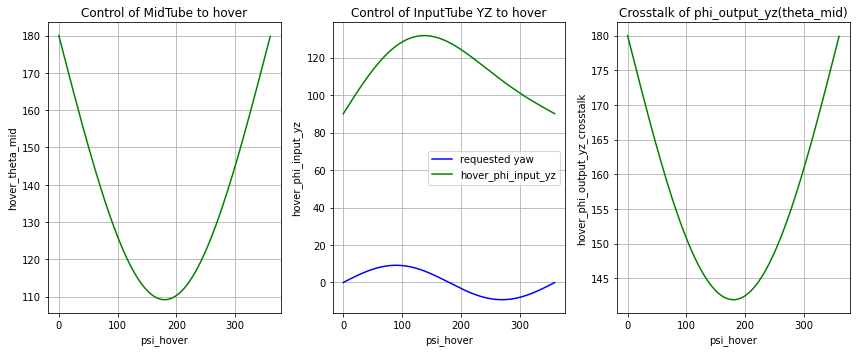

In [32]:
# Plot hover control
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 3, 1)
plt.plot(psi_hover_arr, hover_theta_mid_arr, 'g-')
plt.title('Control of MidTube to hover')
plt.xlabel('psi_hover')
plt.ylabel('hover_theta_mid')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(psi_hover_arr, yaw_arr, 'b-', label = 'requested yaw')
plt.plot(psi_hover_arr, hover_phi_input_yz_arr, 'g-', label = 'hover_phi_input_yz')
plt.title('Control of InputTube YZ to hover')
plt.xlabel('psi_hover')
plt.ylabel('hover_phi_input_yz')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(psi_hover_arr, hover_phi_output_yz_crosstalk_arr, 'g-')
plt.title('Crosstalk of phi_output_yz(theta_mid)')
plt.xlabel('psi_hover')
plt.ylabel('hover_phi_output_yz_crosstalk')
plt.grid()
plt.tight_layout()

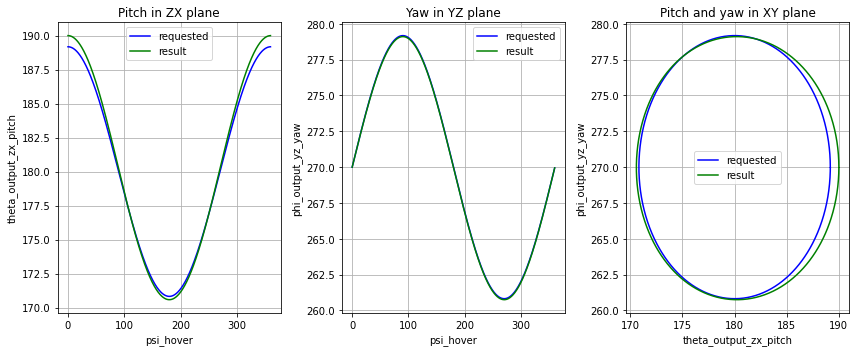

In [33]:
# Plot hover result
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 3, 1)
plt.plot(psi_hover_arr, request_theta_output_zx_pitch_arr, 'b-', label = 'requested')
plt.plot(psi_hover_arr, result_theta_output_zx_pitch_arr, 'g-', label = 'result')
plt.title('Pitch in ZX plane')
plt.xlabel('psi_hover')
plt.ylabel('theta_output_zx_pitch')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(psi_hover_arr, request_phi_output_yz_yaw_arr, 'b-', label = 'requested')
plt.plot(psi_hover_arr, result_phi_output_yz_yaw_arr, 'g-', label = 'result')
plt.title('Yaw in YZ plane')
plt.xlabel('psi_hover')
plt.ylabel('phi_output_yz_yaw')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(request_theta_output_zx_pitch_arr, request_phi_output_yz_yaw_arr, 'b-', label = 'requested')
plt.plot(result_theta_output_zx_pitch_arr, result_phi_output_yz_yaw_arr, 'g-', label = 'result')
plt.title('Pitch and yaw in XY plane')
plt.xlabel('theta_output_zx_pitch')
plt.ylabel('phi_output_yz_yaw')
plt.legend()
plt.grid()
plt.tight_layout()

In [34]:
# Check hover result
# . use 0:N_points//2 range to have only one index for maximum, due to circular hover motion
if output_tube_pointing == 'down':
    hover_pitch_arr = result_theta_output_zx_pitch_arr - sa.theta_output_zx_vertical
else:
    hover_pitch_arr = sa.theta_output_zx_vertical - result_theta_output_zx_pitch_arr
hover_pitch_error_arr = pitch_arr - hover_pitch_arr
hover_pitch_error_max = np.max(np.abs(hover_pitch_error_arr[0:N_points//2]))
hover_pitch_error_max_index = np.argmax(np.abs(hover_pitch_error_arr[0:N_points//2]))
hover_pitch_error_max_psi = psi_hover_arr[hover_pitch_error_max_index]
hover_pitch_error_max_percent = 100 * hover_pitch_error_max / hover_ampl

hover_yaw_arr = result_phi_output_yz_yaw_arr - sa.phi_output_yz_vertical
hover_yaw_error_arr = yaw_arr - hover_yaw_arr
hover_yaw_error_max = np.max(np.abs(hover_yaw_error_arr[0:N_points//2]))
hover_yaw_error_max_index = np.argmax(np.abs(hover_yaw_error_arr[0:N_points//2]))
hover_yaw_error_max_psi = psi_hover_arr[hover_yaw_error_max_index]
hover_yaw_error_max_percent = 100 *  hover_yaw_error_max / hover_ampl

# . ampl = sqrt(pitch**2 + yaw**2) for circular hover motion
hover_ampl_arr = np.sqrt(hover_pitch_arr**2 + hover_yaw_arr**2)
hover_ampl_error_arr = hover_ampl - hover_ampl_arr
hover_ampl_error_max = np.max(np.abs(hover_ampl_error_arr[0:N_points//2]))
hover_ampl_error_max_index = np.argmax(np.abs(hover_ampl_error_arr[0:N_points//2]))
hover_ampl_error_max_psi = psi_hover_arr[hover_ampl_error_max_index]
hover_ampl_error_max_percent = 100 * hover_ampl_error_max / hover_ampl

# Log maximum hover error relative to hover amplitude in percent
print('hover_ampl = %.3f' % hover_ampl)
print('hover_pitch_error_max = %7.3f, hover_pitch_error_max_percent = %6.2f %% at psi_hover = %6.2f degrees' %
      (hover_pitch_error_max, hover_pitch_error_max_percent, hover_pitch_error_max_psi))
print('hover_yaw_error_max   = %7.3f, hover_yaw_error_max_percent   = %6.2f %% at psi_hover = %6.2f degrees' %
      (hover_yaw_error_max, hover_yaw_error_max_percent, hover_yaw_error_max_psi))
print('hover_ampl_error_max  = %7.3f, hover_ampl_error_max_percent  = %6.2f %% at psi_hover = %6.2f degrees' %
      (hover_ampl_error_max, hover_ampl_error_max_percent, hover_ampl_error_max_psi))

hover_ampl = 9.179
hover_pitch_error_max =   0.821, hover_pitch_error_max_percent =   8.94 % at psi_hover =   0.00 degrees
hover_yaw_error_max   =   0.071, hover_yaw_error_max_percent   =   0.77 % at psi_hover =  77.70 degrees
hover_ampl_error_max  =   0.821, hover_ampl_error_max_percent  =   8.94 % at psi_hover =   0.00 degrees


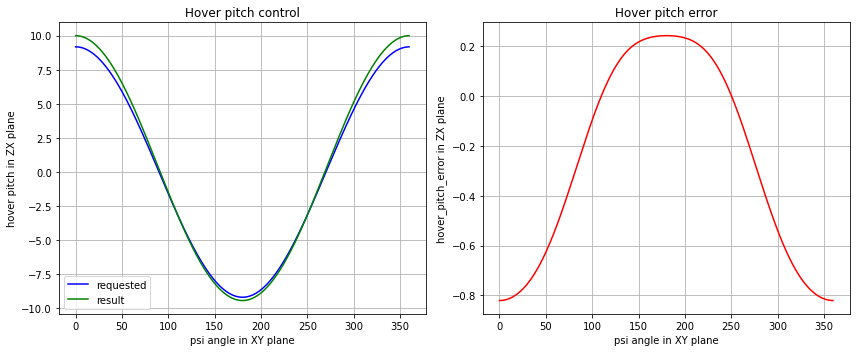

In [35]:
# Plot hover pitch control and error
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 2, 1)
plt.plot(psi_hover_arr, pitch_arr, 'b-', label = 'requested')
plt.plot(psi_hover_arr, hover_pitch_arr, 'g-', label = 'result')
plt.title('Hover pitch control')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover pitch in ZX plane')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(psi_hover_arr, hover_pitch_error_arr, 'r-')
plt.title('Hover pitch error')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover_pitch_error in ZX plane')
plt.grid()
plt.tight_layout()

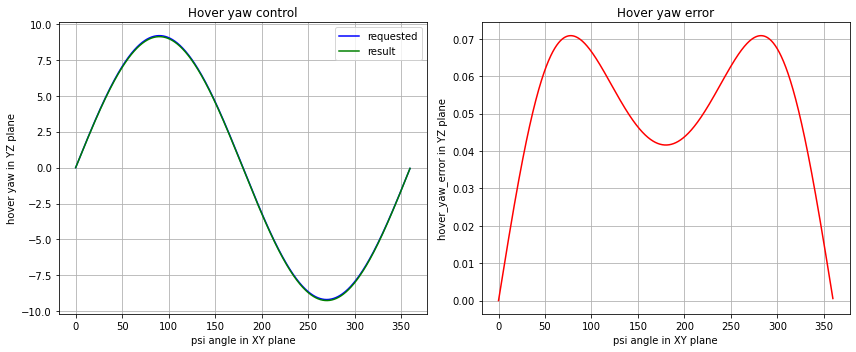

In [36]:
# Plot hover yaw control and error
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 2, 1)
plt.plot(psi_hover_arr, yaw_arr, 'b-', label = 'requested')
plt.plot(psi_hover_arr, hover_yaw_arr, 'g-', label = 'result')
plt.title('Hover yaw control')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover yaw in YZ plane')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(psi_hover_arr, hover_yaw_error_arr, 'r-')
plt.title('Hover yaw error')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover_yaw_error in YZ plane')
plt.grid()
plt.tight_layout()

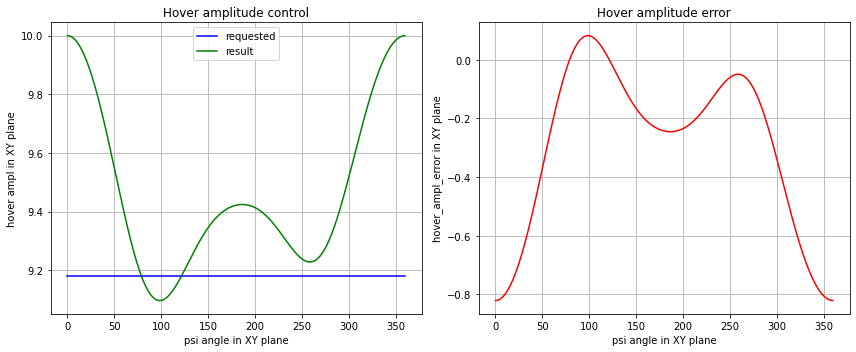

In [37]:
# Plot hover ampl control and error
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 2, 1)
plt.plot(psi_hover_arr, ampl_arr, 'b-', label = 'requested')
plt.plot(psi_hover_arr, hover_ampl_arr, 'g-', label = 'result')
plt.title('Hover amplitude control')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover ampl in XY plane')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(psi_hover_arr, hover_ampl_error_arr, 'r-')
plt.title('Hover amplitude error')
plt.xlabel('psi angle in XY plane')
plt.ylabel('hover_ampl_error in XY plane')
plt.grid()
plt.tight_layout()

# 7. Application: Transition control

Model swivel output movement between horizontal and maximum swivel tilt for transition control.

In [38]:
# Define transition motion to transition swivel between horizontal and maximum tilt in ZX plane:
# . determine theta_mid for theta_output_xr in theta_output_zx
# . determine phi_output_yz due to theta_mid
# . adjust phi_input_yz to get wanted phi_output_yz in ZX plane
print('sa.theta_output_zx_horizontal = ', sa.theta_output_zx_horizontal)

# Select maximum tilt
theta_output_xr_transition_max = sa.swivel_tilt_max  # maximum tilt for exact
theta_output_xr_transition_max = f1_theta_output_xr_ampl  # maximum tilt for approximation
#theta_output_xr_transition_max = swivel_tilt_vertical  # tilt vertical
print('theta_output_xr_transition_max = ', theta_output_xr_transition_max)

request_theta_output_xr_transition_arr = np.linspace(0, theta_output_xr_transition_max, N_points, endpoint=True)
if output_tube_pointing == 'down':
    request_theta_output_zx_transition_arr = sa.theta_output_zx_horizontal + request_theta_output_xr_transition_arr
else:
    request_theta_output_zx_transition_arr = sa.theta_output_zx_horizontal - request_theta_output_xr_transition_arr

sa.theta_output_zx_horizontal =  90
theta_output_xr_transition_max =  99.17936097376193


In [39]:
# Approximate transition control:
# . keep swivel output in vertical ZX plane during transition
request_phi_output_yz_transition = sa.phi_output_yz_vertical

# . approximate theta_mid due to theta_output_xr transition control
transition_theta_mid_arr = sw.approximate_theta_mid_as_function_of_theta_output_xr(
                               request_theta_output_xr_transition_arr,
                               f1_theta_output_xr_ampl,
                               mid_tube_rotation)
    
# . approximate phi_output_yz due to theta_mid
transition_phi_output_yz_crosstalk_arr = sw.approximate_phi_output_yz_as_function_of_theta_mid(
                                             transition_theta_mid_arr,
                                             f1_phi_output_yz_ampl)

# . adjust phi_input_yz for theta_mid crosstalk, to achieve wanted phi_output_yz in YZ plane
transition_phi_input_yz_arr = request_phi_output_yz_transition - transition_phi_output_yz_crosstalk_arr

approximate_theta_mid_as_function_of_theta_output_xr()
. f1_ampl = 99.179
. mid_tube_rotation = positive
approximate_phi_output_yz_as_function_of_theta_mid():
. f1_ampl              = 2.816
. phi_input_yz_for_analysis  = 270


In [40]:
# Apply transition control:
t_vector_list = sw.SwivelThrustVectorsList(x_input, x_mid, x_output, alpha_tilt,
                                           transition_phi_input_yz_arr, transition_theta_mid_arr)

# . get InputTube YZ angles
result_phi_output_yz_transition_arr = la.toAngleArr360(la.fAngleArrYZ(t_vector_list))
# . map OutputTube ZX angles to linear range
if output_tube_pointing == 'down':
    result_theta_output_zx_transition_arr = la.toAngleArr360(la.fAngleArrZX(t_vector_list))
else:
    result_theta_output_zx_transition_arr = la.toAngleArr180(la.fAngleArrZX(t_vector_list))

In [41]:
# Log arrays
if False:
    print('request_theta_output_zx_transition_arr =', request_theta_output_zx_transition_arr)
    print('request_phi_output_yz_transition =', request_phi_output_yz_transition)
    print('transition_theta_mid_arr =', transition_theta_mid_arr)
    print('transition_phi_output_yz_crosstalk_arr =', transition_phi_output_yz_crosstalk_arr)
    print('transition_phi_input_yz_arr =', transition_phi_input_yz_arr)
    print('result_phi_output_yz_transition_arr =', result_phi_output_yz_transition_arr)
    print('result_theta_output_zx_transition_arr =', result_theta_output_zx_transition_arr)

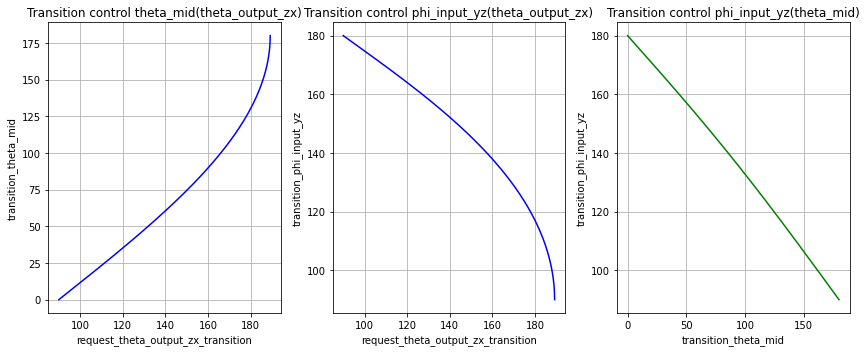

In [42]:
# Plot transition control
fig = plt.figure(figsize=(12, 5))  # width, height in inches
plt.subplot(1, 3, 1)
plt.plot(request_theta_output_zx_transition_arr, transition_theta_mid_arr, 'b-')
plt.title('Transition control theta_mid(theta_output_zx)')
plt.xlabel('request_theta_output_zx_transition')
plt.ylabel('transition_theta_mid')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(request_theta_output_zx_transition_arr, transition_phi_input_yz_arr, 'b-')
plt.title('Transition control phi_input_yz(theta_output_zx)')
plt.xlabel('request_theta_output_zx_transition')
plt.ylabel('transition_phi_input_yz')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(transition_theta_mid_arr, transition_phi_input_yz_arr, 'g-')
plt.title('Transition control phi_input_yz(theta_mid)')
plt.xlabel('transition_theta_mid')
plt.ylabel('transition_phi_input_yz')
plt.grid()
plt.tight_layout()

In [43]:
# Check transition result
transition_phi_output_yz_error_arr = result_phi_output_yz_transition_arr - request_phi_output_yz_transition
transition_theta_output_zx_error_arr = result_theta_output_zx_transition_arr - request_theta_output_zx_transition_arr

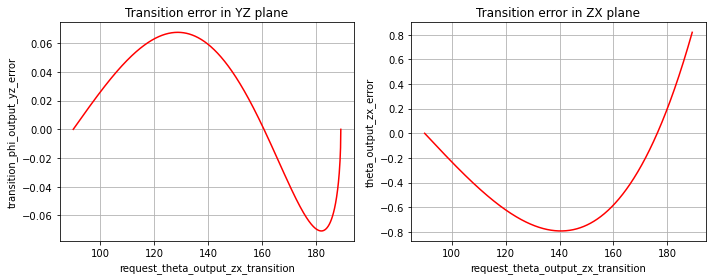

In [44]:
# Plot transition result
fig = plt.figure(figsize=(10, 4))  # width, height in inches
plt.subplot(1, 2, 1)
plt.plot(request_theta_output_zx_transition_arr, transition_phi_output_yz_error_arr, 'r-')
plt.title('Transition error in YZ plane')
plt.xlabel('request_theta_output_zx_transition')
plt.ylabel('transition_phi_output_yz_error')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(request_theta_output_zx_transition_arr, transition_theta_output_zx_error_arr, 'r-')
plt.title('Transition error in ZX plane')
plt.xlabel('request_theta_output_zx_transition')
plt.ylabel('theta_output_zx_error')
plt.grid()
plt.tight_layout()